In [44]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from scipy import integrate

from tqdm.auto import tqdm

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('matplotlibrc')

## 1. No frequency dependence

In [3]:
# nfw
r_s = 1
def n_NFW(r):
    return 1/((r/r_s)*(1+r/r_s)**2)

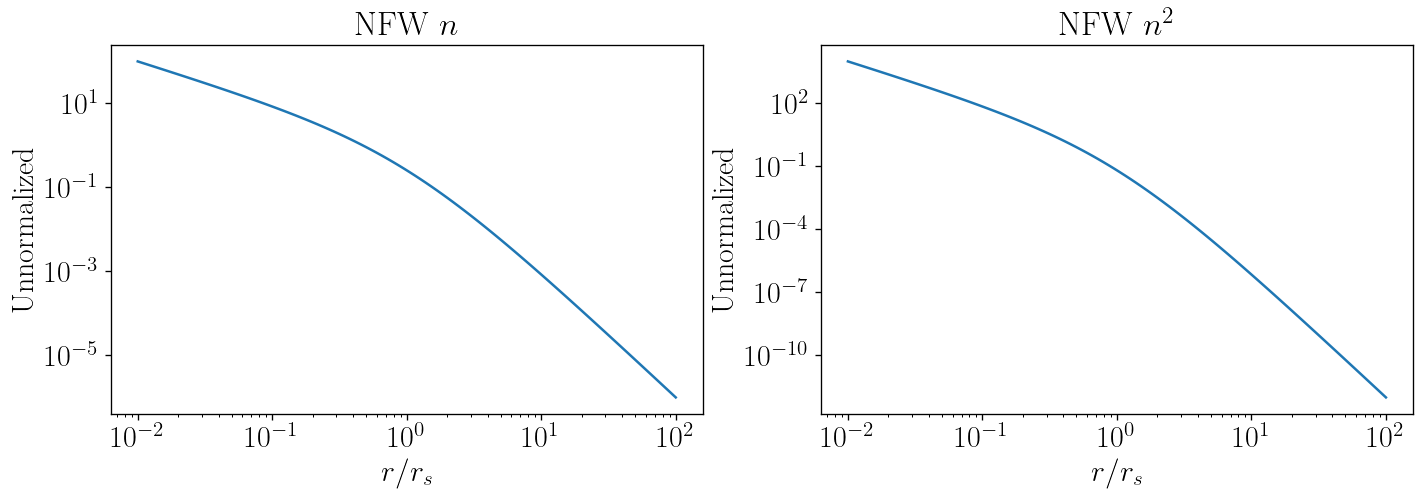

In [40]:
r_arr = np.logspace(-2, 2, 100)
n_arr = np.array([n_NFW(r) for r in r_arr])

fig, axs = plt.subplots(1, 2, figsize=(14,4))
axs[0].plot(r_arr, n_arr)
axs[0].set(xscale='log', yscale='log')
axs[0].set(title=r'NFW $n$', xlabel=r'$r/r_s$', ylabel=r'Unnormalized')

axs[1].plot(r_arr, n_arr**2)
axs[1].set(xscale='log', yscale='log')
axs[1].set(title=r'NFW $n^2$', xlabel=r'$r/r_s$', ylabel=r'Unnormalized');

### 1.1 Just emission: integrate

In [5]:
r_arr = np.logspace(-1, 1, 10) # [r_s]
t_arr = np.linspace(0.01, np.pi, 100) # theta [rad]

decay_Iss = []
for r in tqdm(r_arr):
    Is = []
    for t in t_arr:
        b = r*np.sin(t)
        def integrand(s):
            return n_NFW(np.sqrt(s**2+b**2))
        I = integrate.quad(integrand, -200, r*np.cos(t))[0]
        Is.append(I)
    decay_Iss.append(Is)
decay_Iss = np.array(decay_Iss)

annih_Iss = []
for r in tqdm(r_arr):
    Is = []
    for t in t_arr:
        b = r*np.sin(t)
        def integrand(s):
            return n_NFW(np.sqrt(s**2+b**2))**2
        I = integrate.quad(integrand, -200, r*np.cos(t))[0]
        Is.append(I)
    annih_Iss.append(Is)
annih_Iss = np.array(annih_Iss)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.80it/s]


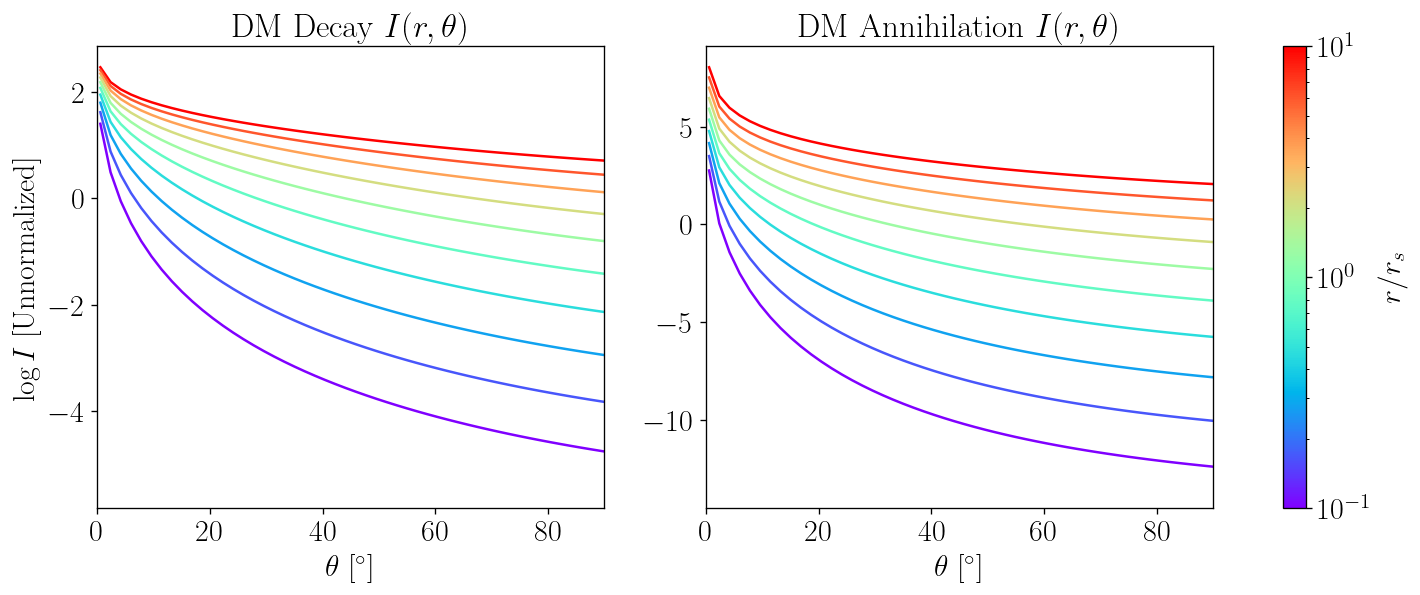

In [49]:
cmap = plt.get_cmap('rainbow')

fig, axs = plt.subplots(1, 2, figsize=(15,5))
for i, Is in enumerate(decay_Iss):
    axs[0].plot(t_arr*180/np.pi, np.log(Is), color=cmap(1-i/(len(decay_Iss)-1)))
axs[0].set(xlim=(0, 90), ylim=None)
axs[0].set(title=r'DM Decay $I(r,\theta)$', xlabel=r'$\theta$ [$^\circ$]', ylabel=r'$\log I$ [Unnormalized]')

for i, Is in enumerate(annih_Iss):
    axs[1].plot(t_arr*180/np.pi, np.log(Is), color=cmap(1-i/(len(annih_Iss)-1)))
axs[1].set(xlim=(0, 90), ylim=None)
axs[1].set(title=r'DM Annihilation $I(r,\theta)$', xlabel=r'$\theta$ [$^\circ$]')

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e1), cmap=cmap),
             ax=axs, label='$r/r_s$')

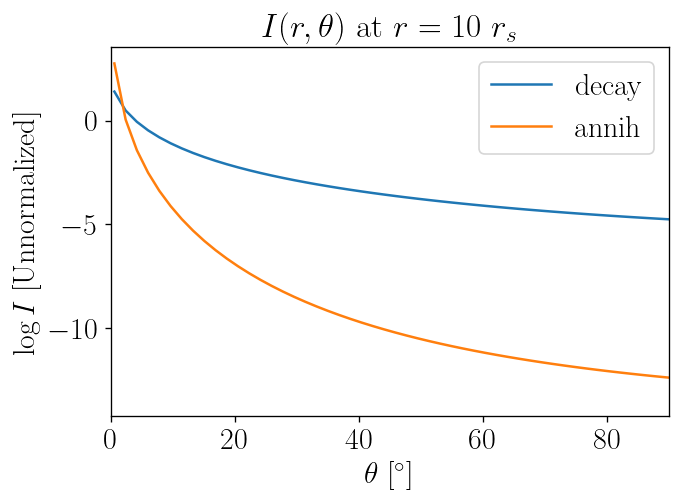

In [66]:
# benchmark point r = 10 r_s
fig, ax = plt.subplots()
ax.plot(t_arr*180/np.pi, np.log(decay_Iss[-1]), label='decay')
ax.plot(t_arr*180/np.pi, np.log(annih_Iss[-1]), label='annih')
ax.set(xlim=(0, 90), ylim=None)
ax.set(title=r'$I(r,\theta)$ at $r=10~r_s$', xlabel=r'$\theta$ [$^\circ$]', ylabel=r'$\log I$ [Unnormalized]')
ax.legend();

### 1.2 Emission and absorption: first order ODE

In [58]:
r_edge = 1000
def s_start(r, t):
    b = r * np.sin(t)
    return - np.sqrt(r_edge**2-b**2)
def s_end(r, t):
    return r * np.cos(t)

In [100]:
n_NFW(0.1)**2

68.30134553650706

In [124]:
def I_ja(r, t, a_norm=1):
    
    b = r*np.sin(t)
    def j(r):
        return n_NFW(r)**2
    def a_NFW(r):
        return a_norm * n_NFW(r)
    def dIds(s, I):
        r = np.sqrt(s**2+b**2)
        return j(r) - a_NFW(r) * I
    sol = integrate.ode(dIds).set_integrator('dopri5', method='bdf')
    # sol.set_f_params(b)
    sol.set_initial_value(0, s_start(r, t))
    sol.integrate(s_end(r, t))
    if not sol.successful():
        print(r, t)
        raise RuntimeError('solving failed!')
    return sol.y[0]

In [118]:
I_ja(10, 1, a_norm=10)

1.5334995588808314e-05

In [119]:
annih_I_ja_s = [I_ja(10, t, a_norm=10) for t in t_arr]

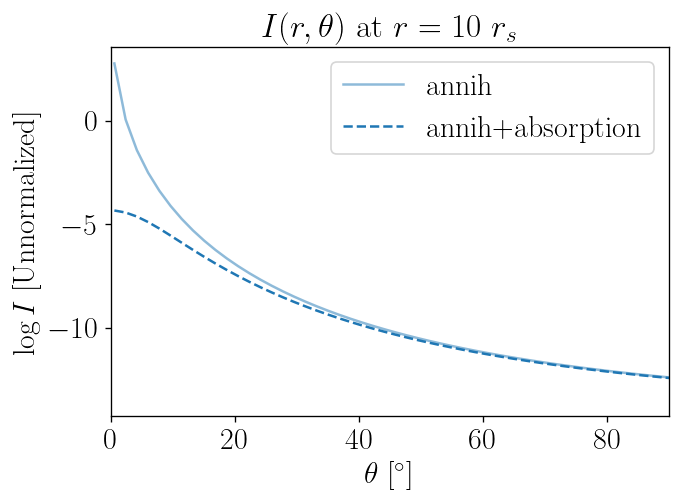

In [120]:
fig, ax = plt.subplots()
ax.plot(t_arr*180/np.pi, np.log(annih_Iss[-1]), label='annih', color='C0', alpha=0.5)
ax.plot(t_arr*180/np.pi, np.log(annih_I_ja_s), label='annih+absorption', color='C0', linestyle='--')
ax.set(xlim=(0, 90), ylim=None)
ax.set(title=r'$I(r,\theta)$ at $r=10~r_s$', xlabel=r'$\theta$ [$^\circ$]', ylabel=r'$\log I$ [Unnormalized]')
ax.legend();

### 1.3 Emission, absorption and uniform scattering: iterative solution

In [128]:
from scipy import interpolate

In [127]:
r_arr = np.logspace(0.1, 1, 100)
t_arr = np.linspace(0.01, np.pi, 100)
I_init = np.zeros((100,100))
for ir, r in enumerate(r_arr):
    for it, t in enumerate(t_arr):
        I_init[ir][it] = I_ja(r, t, a_norm=10)

In [132]:
I = I_init.copy()
I_interp = interpolate.interp2d(r_arr, t_arr, I_init, fill_value=0)
I_int = np.zeros((100,))
for ir, row in enumerate(I):
    t_func = interpolate.interp1d(t_arr, row, fill_value=0)
    def integrand(t):
        t = np.maximum(t, 0.01)
        return 2*np.pi*np.sin(t)*t_func(t)
    I_int[ir] = integrate.quad(integrand, 0, np.pi)[0]
I_int_interp = interpolate.interp1d(r_arr, I_int, fill_value=0)

/var/folders/24/spnpknrj5vb_jzkn8lgg5gth0000gn/T/ipykernel_22289/2840374955.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I_int[ir] = integrate.quad(integrand, 0, np.pi)[0]
/var/folders/24/spnpknrj5vb_jzkn8lgg5gth0000gn/T/ipykernel_22289/2840374955.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I_int[ir] = integrate.quad(integrand, 0, np.pi)[0]


In [ ]:
def I_jas(r, t, a_norm=1, k_norm):
    
    b = r*np.sin(t)
    def j(r):
        return n_NFW(r)**2
    def a_NFW(r):
        return a_norm * n_NFW(r)
    def dIds(s, I):
        r = np.sqrt(s**2+b**2)
        return j(r) - a_NFW(r) * I
    sol = integrate.ode(dIds).set_integrator('dopri5', method='bdf')
    # sol.set_f_params(b)
    sol.set_initial_value(0, s_start(r, t))
    sol.integrate(s_end(r, t))
    if not sol.successful():
        print(r, t)
        raise RuntimeError('solving failed!')
    return sol.y[0]